# Import required libraries

In [6]:
# do 'pip install biopython' if not installed already

In [7]:
from Bio import Entrez, SeqIO

## Download fasta

In [31]:

# Set your email before using Entrez
# Entrez.email = "your_email@example.com"   # will give some warning if email not give, but will work in both cases

# Search for the gene F56F11.4 in NCBI nucleotide database
handle = Entrez.esearch(db="nucleotide", term="F56F11.4[Gene] AND Caenorhabditis elegans[Organism]")
record = Entrez.read(handle)
handle.close()

# Get the first hit (you can loop if multiple hits)
gene_id = record["IdList"][0]
print("NCBI ID:", gene_id)

# Fetch the fasta sequence
fetch_handle = Entrez.efetch(db="nucleotide", id=gene_id, rettype="fasta", retmode="text")
seq_record = SeqIO.read(fetch_handle, "fasta")
fetch_handle.close()

# Print info
print("ID:", seq_record.id)
print("Description:", seq_record.description)
print("Sequence length:", len(seq_record.seq))

# Save to file
with open("F56F11.4.fasta", "w") as f:
    SeqIO.write(seq_record, f, "fasta")


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

# Read fasta

In [9]:
fasta_file = "F56F11.4.fasta"

for record in SeqIO.parse(fasta_file, "fasta"):
    record_id = record.id
    record_description = record.description
    sequence = str(record.seq)
    
    print("ID:", record_id)
    print("Description:", record_description)
    print("Sequence:", sequence)

ID: NM_001393300.1
Description: NM_001393300.1 Caenorhabditis elegans AAA+ ATPase domain-containing protein (F56F11.4), mRNA
Sequence: AATGGGTCCAGCTCCAGTTTTCCCAAATTCGCGGAAGCCGGCGACACTTGACGCGAACTCTGACGAGCAGACACTTCGTCCGTATTTTAAGACGAAAGTTGAACAAGCGGAGCAAACCGTCGCCGAAAAGTCGATCAACGTTCGCCGCCTAATGGCTCAACAAAAAGAGCTCAACGGAAAAGTGCGACTGCTCAAAGAAGAGATCTCACATCTTCACGAGCAGGGAAGTCATGTCGGAGAAGTGTGCAAAGCGATGGATAAAAAGAAAGTGCTCGTCAAGAATCATCCCGATGGAAAATATATTGTCGATGTGGCAGCCAGTGTGGATATTTCTACATTGGCAGCTGGAACTCGTGTTGCTCTTCGAGCTGATAATTATGCAATTCATGAGGTTCTTCCGAGTAAAGTCGATCCTCTTGTGTCGCTTATGATGGTTGAAAAGGTTCCCGATTCAACATATGAAATGGTTGGAGGCCTCGACACACAAATCAAAGAAATTAAAGAAGTAATTGAACTTCCAGTCAAACATCCAGAACTATTTGATGCTCTTGGAATTGCTCAACCAAAAGGAGTACTGCTCTACGGACCCCCGGGAACAGGAAAAACTTTATTGGCTCGAGCGGTGGCTCATCACACTGAATGCACATTTATTCGTGTATCTGGATCTGAATTAGTTCAGAAATTCATTGGAGAAGGCGCCAGAATGGTTCGTGAACTATTTGTAATGGCTCGTGAACATGCTCCATCAATCATTTTTATGGATGAAATTGATTCAATTGGTTCAAGTCGTGTTGAAGGATCACGTGGTGGAGATTCAGAAGTTCAGAGAACAATGCTTGAATTGCTTAATCAATTGGATGGATTT

In [8]:
len(sequence)

1351

In [10]:
from Bio import SeqIO
import matplotlib.pyplot as plt
from collections import Counter
from Bio.Seq import Seq

# 1. Plot nucleotide densities (like ntdensity)
def ntdensity(seq, window=200):
    seq = seq.upper()
    x = [i+window//2 for i in range(0, len(seq)-window, window)]
    for nt in "ATGC":
        y = [window_seq.count(nt)/window for window_seq in [seq[i:i+window] for i in range(0, len(seq)-window, window)]]
        plt.plot(x, y, label=nt)
    plt.legend(); plt.xlabel("Position"); plt.ylabel("Fraction"); plt.title("Nucleotide Density"); plt.show()

# 2. Count monomers (basecount)
def basecount(seq):
    seq = seq.upper()
    return Counter(seq)

# 3. Basecount of reverse complement
def basecount_rc(seq):
    return basecount(Seq(seq).reverse_complement())

# 4. basecount with chart (pie)
def basecount_pie(seq):
    counts = basecount(seq)
    plt.pie(counts.values(), labels=counts.keys(), autopct="%1.1f%%")
    plt.title("Nucleotide Distribution"); plt.show()

# 5. Dimer count with bar chart (dimercount)
def dimercount(seq, chart=True):
    seq = seq.upper()
    dimers = [seq[i:i+2] for i in range(len(seq)-1)]
    counts = Counter(dimers)
    if chart:
        plt.bar(counts.keys(), counts.values())
        plt.title("Dimer Counts"); plt.xlabel("Dimers"); plt.ylabel("Count")
        plt.show()
    return counts


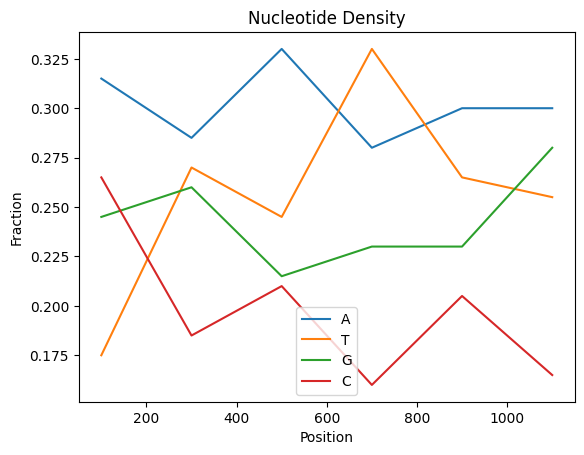

Counter({'A': 408, 'T': 369, 'G': 319, 'C': 255})
Counter({'T': 408, 'A': 369, 'C': 319, 'G': 255})


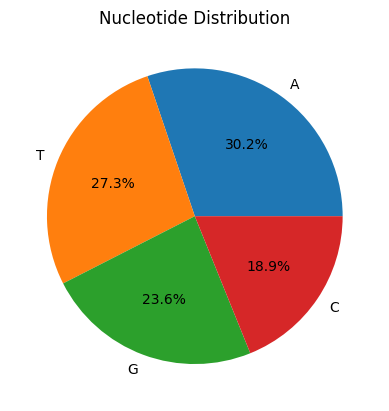

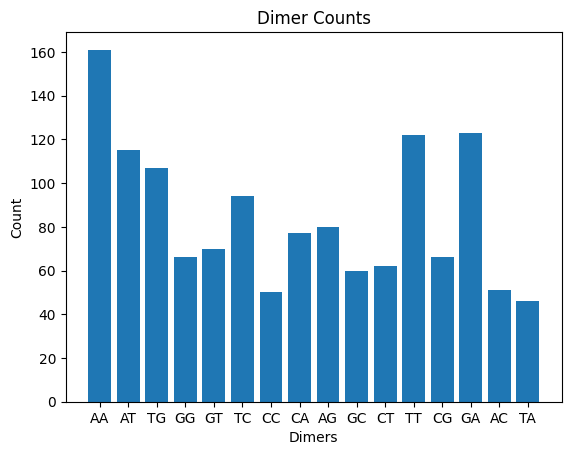

Counter({'AA': 161, 'GA': 123, 'TT': 122, 'AT': 115, 'TG': 107, 'TC': 94, 'AG': 80, 'CA': 77, 'GT': 70, 'GG': 66, 'CG': 66, 'CT': 62, 'GC': 60, 'AC': 51, 'CC': 50, 'TA': 46})


In [11]:
record = SeqIO.read("F56F11.4.fasta", "fasta")
sequence = str(record.seq)

ntdensity(sequence)                  # 1
print(basecount(sequence))           # 2
print(basecount_rc(sequence))        # 3
basecount_pie(sequence)              # 4
print(dimercount(sequence))          # 5


In [12]:
from Bio.Seq import Seq
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# All 64 codons in lexicographic order
bases = ["T", "C", "A", "G"]
all_codons = [a+b+c for a in bases for b in bases for c in bases]

def codoncount(seq, frame=1, reverse=False, plot_ax=None):
    """Count codons in given frame (1,2,3) and optionally reverse strand."""
    seq = Seq(str(seq).upper())
    if reverse:
        seq = seq.reverse_complement()
    seq = seq[frame-1:]  # adjust for reading frame
    
    codons = [str(seq[i:i+3]) for i in range(0, len(seq)-2, 3)]
    counts = Counter(codons)
    
    # Fill missing codons with 0
    codon_vector = [counts.get(c, 0) for c in all_codons]
    codon_matrix = np.array(codon_vector).reshape(4,16)  # 4x16 heatmap like MATLAB
    
    # Plot on provided axis
    if plot_ax is not None:
        sns.heatmap(codon_matrix, ax=plot_ax,
                    xticklabels=all_codons[0:16],
                    yticklabels=["T","C","A","G"],
                    cmap="viridis", cbar=False)
        plot_ax.set_xlabel("Codons")
        plot_ax.set_ylabel("First base")
    
    return counts





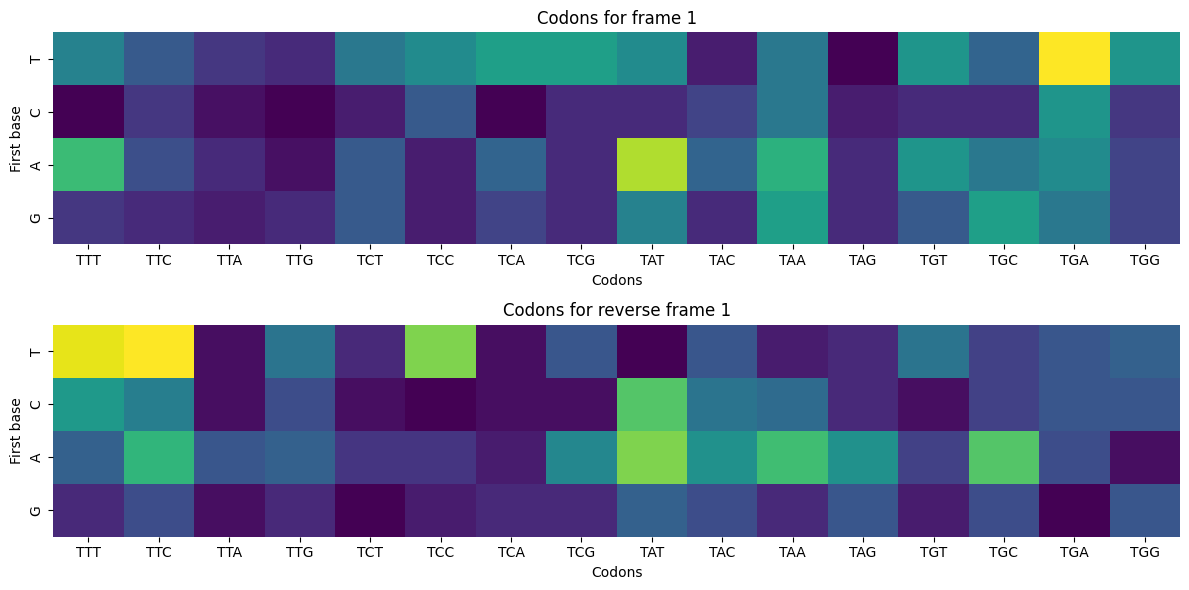

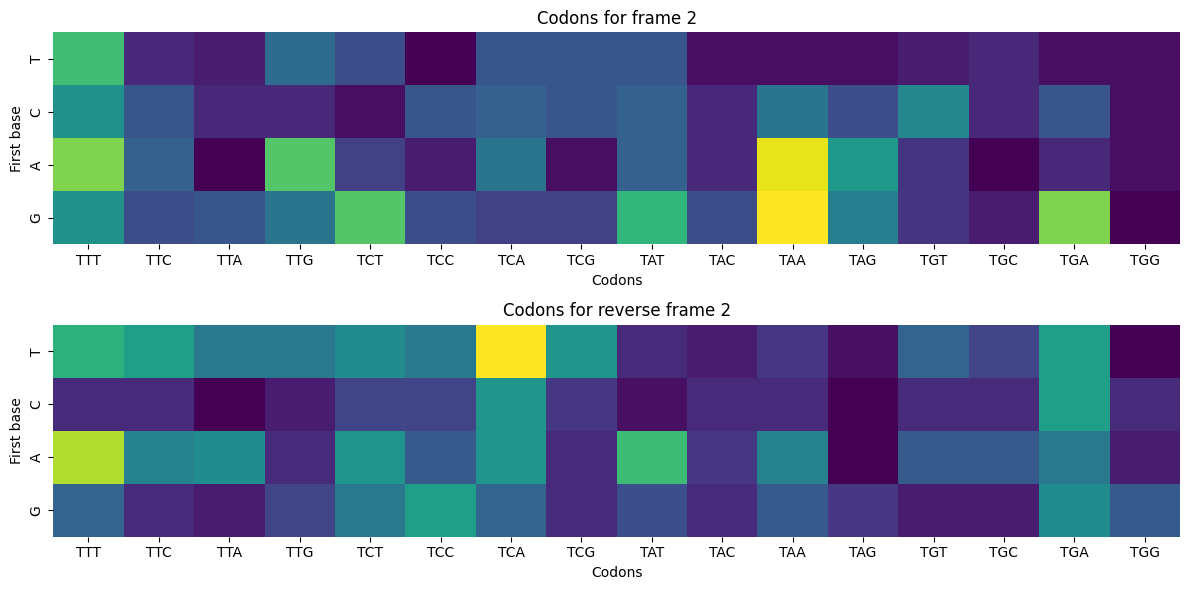

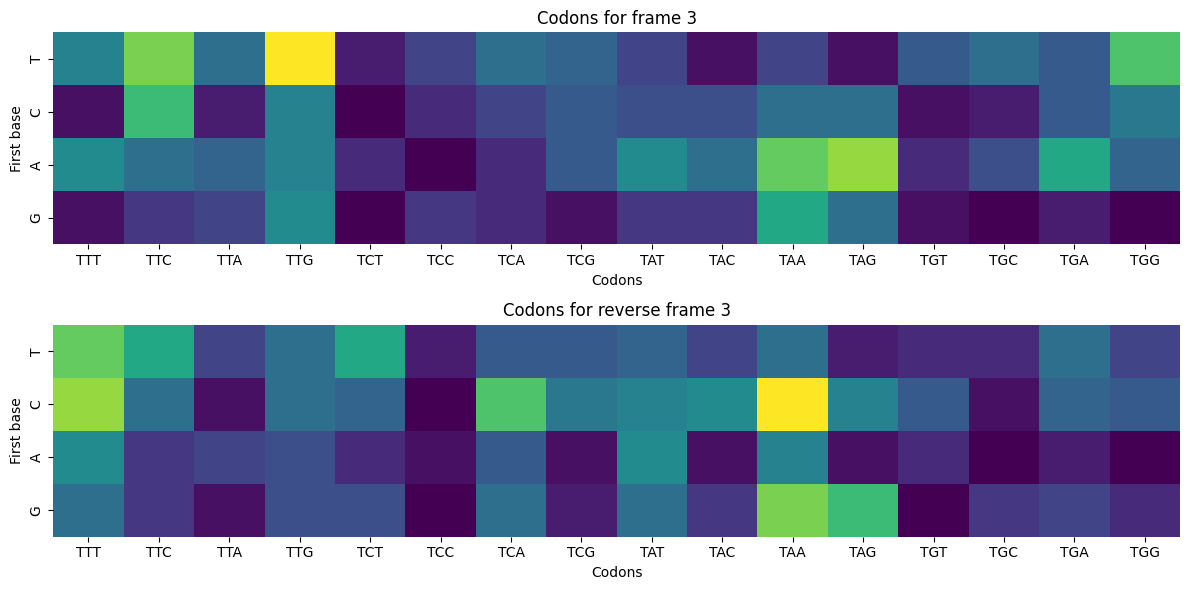

In [13]:
# Example usage: plot all 6 reading frames
for frame in [1,2,3]:
    fig, axes = plt.subplots(2, 1, figsize=(12,6))
    
    codoncount(sequence, frame=frame, reverse=False, plot_ax=axes[0])
    axes[0].set_title(f"Codons for frame {frame}")
    
    codoncount(sequence, frame=frame, reverse=True, plot_ax=axes[1])
    axes[1].set_title(f"Codons for reverse frame {frame}")
    
    plt.tight_layout()
    plt.show()

In [9]:
from Bio import Entrez, SeqIO

Entrez.email = "your_email@example.com"   # required
# Entrez.api_key = "YOUR_NCBI_API_KEY"    # optional but recommended

def fetch_seq_by_gene(gene_symbol, organism, fasta_file,rettype="fasta"):
    term = f'{gene_symbol}[Gene] AND "{organism}"[Organism] AND biomol_mrna[PROP] AND refseq[filter]'
    handle = Entrez.esearch(db="nucleotide", term=term, retmax=1)
    rec = Entrez.read(handle)
    ids = rec.get("IdList", [])
    if not ids:
        raise ValueError(f"No RefSeq mRNA found for {gene_symbol} in {organism}")
    seq_id = ids[0]
    fh = Entrez.efetch(db="nucleotide", id=seq_id, rettype=rettype, retmode="text")
    record = SeqIO.read(fh, "fasta")
    fh.close()
    SeqIO.write(record, fasta_file, "fasta")
    print(f"✅ Saved {gene_symbol} ({organism}) sequence to {fasta_file}")
    return record


In [10]:
human = fetch_seq_by_gene("HEXA", "Homo sapiens",fasta_file='human_hexa.fasta')
mouse = fetch_seq_by_gene("HEXA", "Mus musculus",fasta_file='mouse_hexa.fasta')

print(human.id, len(human.seq))
print(mouse.id, len(mouse.seq))


✅ Saved HEXA (Homo sapiens) sequence to human_hexa.fasta
✅ Saved HEXA (Mus musculus) sequence to mouse_hexa.fasta
NM_000520.6 4785
NM_001410424.1 1942


In [12]:
# seq_tools.py
from Bio import Entrez, SeqIO
from Bio.Seq import Seq
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
#  seqdotplot
# ---------------------------
def seqdotplot(seq1, seq2, window=1, threshold=None, kind='matrix', cmap='gray_r', figsize=(8,8),
                xlabel=None, ylabel=None, title=None, show=True):
    """
    Create a dotplot between seq1 and seq2.
    - seq1, seq2: str or Bio.Seq.Seq
    - window: integer sliding window length for match (1 = exact base match). For longer windows, counts matches across window.
    - threshold: if None, default threshold = window (i.e., require full-window match); if <1 and >0, treated as fraction of window.
                 If integer >=1, treated as minimal number of matching positions in window to place a dot.
    - kind: 'matrix' -> show full 2D intensity matrix; 'dots' -> scatter of dot positions (faster for sparse).
    Returns the matrix (numpy array) of match counts / boolean.
    """
    s1 = str(seq1).upper()
    s2 = str(seq2).upper()
    n1, n2 = len(s1), len(s2)
    if n1 < window or n2 < window:
        raise ValueError("Window longer than sequence length.")
    # Default threshold: require full-window match
    if threshold is None:
        thr = window
    else:
        # fraction -> convert to integer required matches
        if 0 < threshold < 1:
            thr = int(np.ceil(threshold * window))
        else:
            thr = int(threshold)

    # Build match matrix: for each position i in s1 (window start) and j in s2, compute matches in window
    rows = n1 - window + 1
    cols = n2 - window + 1
    M = np.zeros((rows, cols), dtype=int)

    # Efficient sliding-window approach: vectorized-ish by rolling windows (but kept simple/readable)
    for i in range(rows):
        w1 = s1[i:i+window]
        # convert to numpy char arrays to compare quickly
        for j in range(cols):
            w2 = s2[j:j+window]
            # count matches in window
            match_count = sum(1 for a,b in zip(w1, w2) if a == b)
            if match_count >= thr:
                M[i, j] = match_count

    if show:
        plt.figure(figsize=figsize)
        if kind == 'matrix':
            # intensity image (higher value -> stronger match)
            plt.imshow(M.T, origin='lower', aspect='auto', cmap=cmap)
            plt.colorbar(label='matching positions in window')
        else:
            # scatter plot of coordinates where match occurs
            coords = np.argwhere(M > 0)
            if coords.size == 0:
                plt.text(0.5, 0.5, 'no matches', ha='center')
            else:
                xs, ys = coords[:,0], coords[:,1]
                plt.scatter(xs + window//2, ys + window//2, s=1)
            plt.gca().invert_yaxis()  # optional: match MATLAB orientation preference
        plt.xlabel(xlabel or f"Seq1 (len={n1})")
        plt.ylabel(ylabel or f"Seq2 (len={n2})")
        plt.title(title or f"Dotplot: window={window}, threshold={thr}")
        plt.tight_layout()
        plt.show()

    return M

# ---------------------------
# C: convenience wrapper to do human vs mouse dotplot for a gene
# ---------------------------
def gene_dotplot_human_mouse(seq_h,seq_m,gene_symbol, human_org="Homo sapiens", mouse_org="Mus musculus",
                             window=1, threshold=None, **dotplot_kwargs):
    """
    Fetch gene (nucleotide) sequences for human and mouse and plot dotplot.
    Returns (seq_human, seq_mouse, matrix)
    Use accession strings instead of gene_symbol if you prefer exact control.
    """
    # seq_h = fetch_seq_by_gene(gene_symbol, human_org)
    # seq_m = fetch_seq_by_gene(gene_symbol, mouse_org)

    # seq_h = sequence
    # seq_m = sequence

    M = seqdotplot(seq_h, seq_m, window=window, threshold=threshold, xlabel=human_org, ylabel=mouse_org, title=f"{gene_symbol}: human vs mouse", **dotplot_kwargs)
    return M


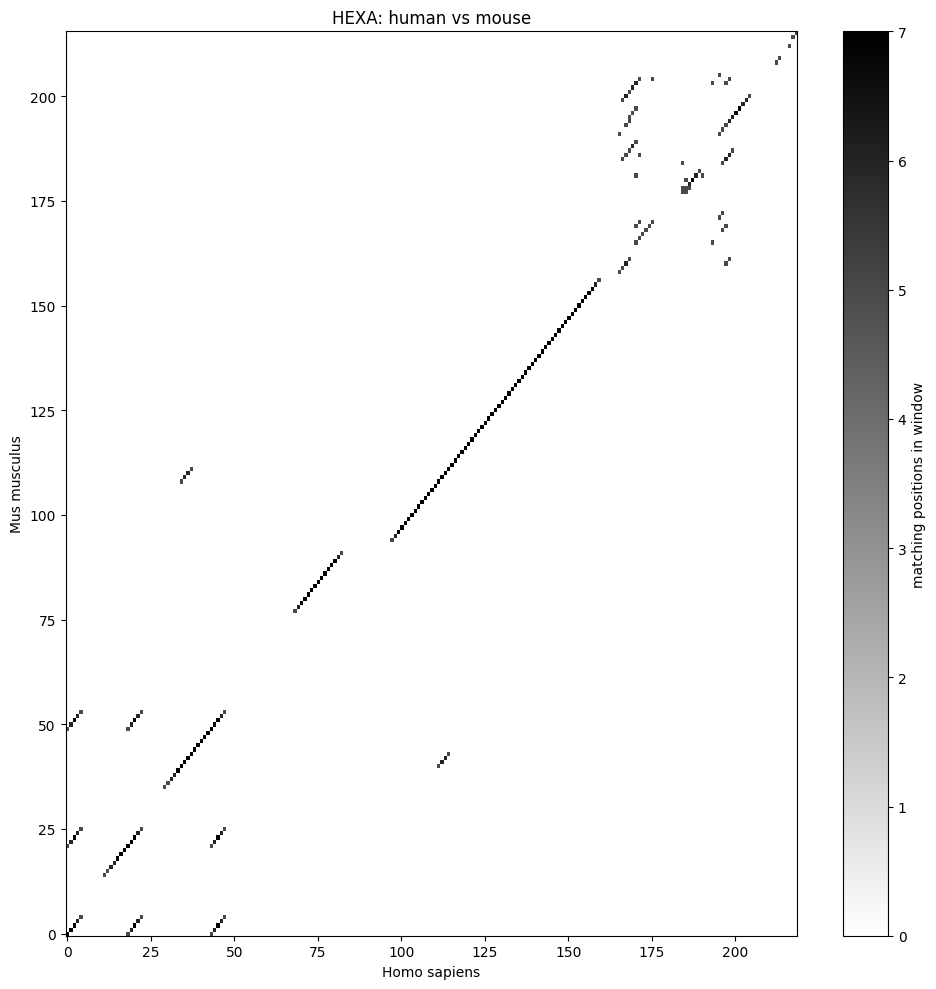

In [14]:
# from seq_tools import gene_dotplot_human_mouse

# hexosaminidase A examples (if you meant "hexosaminidase")
seq_h = human
seq_m = mouse
M = gene_dotplot_human_mouse(seq_h, seq_m, "HEXA", window=7, threshold=5, figsize=(10,10))
# window=7 with threshold=5: show positions where at least 5/7 bases match in the window


In [16]:
from Bio.Seq import Seq

# --- Conversions between nucleotides, amino acids, ints ---

# 1. Amino acid -> integer mapping (1-based like MATLAB convention, A=1,...,Y=20)
aa_list = list("ARNDCQEGHILKMFPSTWYV")  # 20 standard aa
aa2int_map = {aa: i+1 for i, aa in enumerate(aa_list)}
int2aa_map = {i+1: aa for i, aa in enumerate(aa_list)}

def aa2int(aa):
    return [aa2int_map.get(a, 0) for a in str(aa).upper()]

def int2aa(ints):
    return ''.join(int2aa_map.get(i, 'X') for i in ints)

# 2. Nucleotide <-> integer (A=1, C=2, G=3, T/U=4)
nt_list = ["A", "C", "G", "T"]
nt2int_map = {nt: i+1 for i, nt in enumerate(nt_list)}
int2nt_map = {i+1: nt for i, nt in enumerate(nt_list)}

def nt2int(seq):
    return [nt2int_map.get(n, 0) for n in str(seq).upper().replace("U","T")]

def int2nt(ints):
    return ''.join(int2nt_map.get(i, 'N') for i in ints)

# 3. Codon <-> amino acid (translate DNA/RNA to protein)
def nt2aa(seq, table=1):
    return str(Seq(str(seq)).translate(table=table))

def aa2nt(aa, codon_table=1):
    # Pick the first codon for each amino acid from translation table
    from Bio.Data import CodonTable
    table = CodonTable.unambiguous_dna_by_id[codon_table]
    aa = str(aa).upper()
    seq = []
    for a in aa:
        if a in table.forward_table.values():
            codon = [k for k,v in table.forward_table.items() if v==a][0]
            seq.append(codon)
        elif a == "*":
            seq.append(table.stop_codons[0])
        else:
            seq.append("NNN")
    return ''.join(seq)

# 4. DNA <-> RNA
def dna2rna(seq):
    return str(seq).upper().replace("T","U")

def rna2dna(seq):
    return str(seq).upper().replace("U","T")

# 5. Sequence operations
def seqcomplement(seq):
    return str(Seq(str(seq)).complement())

def seqrcomplement(seq):
    return str(Seq(str(seq)).reverse_complement())

def seqreverse(seq):
    return str(seq)[::-1]


In [17]:
print(aa2int("MKT"))         # [13, 12, 17]
print(int2aa([13,12,17]))    # "MKT"

print(nt2int("ATGC"))        # [1,4,3,2]
print(int2nt([1,4,3,2]))     # "ATGC"

print(nt2aa("ATGGCC"))       # "MA"
print(aa2nt("MA"))           # "ATGGCC"

print(dna2rna("ATGC"))       # "AUGC"
print(rna2dna("AUGC"))       # "ATGC"

print(seqcomplement("ATGC"))     # "TACG"
print(seqrcomplement("ATGC"))    # "GCAT"
print(seqreverse("ATGC"))        # "CGTA"


[13, 12, 17]
MKT
[1, 4, 3, 2]
ATGC
MA
ATGGCT
AUGC
ATGC
TACG
GCAT
CGTA


In [18]:
from collections import Counter

# Atomic composition of amino acids (monoisotopic, no terminal modifications)
aa_atoms = {
    "A": {"C":3,"H":7,"N":1,"O":2},   # Alanine
    "R": {"C":6,"H":14,"N":4,"O":2},  # Arginine
    "N": {"C":4,"H":8,"N":2,"O":3},   # Asparagine
    "D": {"C":4,"H":7,"N":1,"O":4},   # Aspartic Acid
    "C": {"C":3,"H":7,"N":1,"O":2,"S":1},
    "E": {"C":5,"H":9,"N":1,"O":4},
    "Q": {"C":5,"H":10,"N":2,"O":3},
    "G": {"C":2,"H":5,"N":1,"O":2},
    "H": {"C":6,"H":9,"N":3,"O":2},
    "I": {"C":6,"H":13,"N":1,"O":2},
    "L": {"C":6,"H":13,"N":1,"O":2},
    "K": {"C":6,"H":14,"N":2,"O":2},
    "M": {"C":5,"H":11,"N":1,"O":2,"S":1},
    "F": {"C":9,"H":11,"N":1,"O":2},
    "P": {"C":5,"H":9,"N":1,"O":2},
    "S": {"C":3,"H":7,"N":1,"O":3},
    "T": {"C":4,"H":9,"N":1,"O":3},
    "W": {"C":11,"H":12,"N":2,"O":2},
    "Y": {"C":9,"H":11,"N":1,"O":3},
    "V": {"C":5,"H":11,"N":1,"O":2}
}

def atomic_composition(seq):
    comp = Counter()
    for aa in seq:
        if aa in aa_atoms:
            comp.update(aa_atoms[aa])
    # Adjust for peptide bond formation: each bond removes H2O
    n_bonds = len(seq)-1
    comp["H"] -= 2*n_bonds
    comp["O"] -= n_bonds
    return dict(comp)

# Example: Human HEXA (short fragment)
seq = "MVLTIYPDELVQIVSDKK"
print(atomic_composition(seq))


{'C': 95, 'H': 159, 'N': 21, 'O': 29, 'S': 1}


In [19]:
from Bio.SeqUtils import molecular_weight

seq = "MVLTIYPDELVQIVSDKK"
mw = molecular_weight(seq, seq_type="protein")
print(mw)


2091.4669


In [20]:
# You can also set monoisotopic=True if you want exact monoisotopic weight instead of average:
mw_mono = molecular_weight(seq, seq_type="protein", monoisotopic=True)
print(mw_mono)


2090.133327


In [21]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

seq = "MVLTIYPDELVQIVSDKK"
prot = ProteinAnalysis(seq)

print("Length:", len(seq))
print("Molecular Weight:", prot.molecular_weight())
print("Aromaticity:", prot.aromaticity())
print("Instability Index:", prot.instability_index())
print("Isoelectric Point (pI):", prot.isoelectric_point())
print("GRAVY (hydropathy):", prot.gravy())
print("Amino Acid Percent Composition:", prot.get_amino_acids_percent())


Length: 18
Molecular Weight: 2091.4669
Aromaticity: 0.05555555555555555
Instability Index: 2.677777777777778
Isoelectric Point (pI): 4.556577491760254
GRAVY (hydropathy): 0.27222222222222214
Amino Acid Percent Composition: {'A': 0.0, 'C': 0.0, 'D': 0.1111111111111111, 'E': 0.05555555555555555, 'F': 0.0, 'G': 0.0, 'H': 0.0, 'I': 0.1111111111111111, 'K': 0.1111111111111111, 'L': 0.1111111111111111, 'M': 0.05555555555555555, 'N': 0.0, 'P': 0.05555555555555555, 'Q': 0.05555555555555555, 'R': 0.0, 'S': 0.05555555555555555, 'T': 0.05555555555555555, 'V': 0.16666666666666669, 'W': 0.0, 'Y': 0.05555555555555555}


/home/ashwani/.local/lib/python3.10/site-packages/Bio/SeqUtils/ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


In [22]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

seq1 = "GATTACA"
seq2 = "GCATGCU"

# Global alignment (Needleman-Wunsch)
alignments = pairwise2.align.globalxx(seq1, seq2)

# Print top alignment
print(format_alignment(*alignments[0]))


G-ATTA-CA-
| | |  |  
GCA-T-GC-U
  Score=4



/home/ashwani/.local/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [23]:
# globalxx = global alignment with match = 1, mismatch = 0, no gap penalties

# For more realistic scoring (like substitution matrices + gap penalties):
alignments = pairwise2.align.globalms(seq1, seq2, match=2, mismatch=-1, open=-0.5, extend=-0.1)
print(format_alignment(*alignments[0]))


G-ATTA-CA-
| ||   |  
GCAT--GC-U
  Score=5.4



In [24]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

seq1 = "GATTACA"
seq2 = "GCATGCU"

# Local alignment (Smith-Waterman)
alignments = pairwise2.align.localxx(seq1, seq2)

# Print top alignment
print(format_alignment(*alignments[0]))


1 G-ATTA-C
  | | |  |
1 GCA-T-GC
  Score=4



In [25]:
# localxx → local alignment, match=1, mismatch=0, no gap penalties
# localms → local alignment with custom scoring

alignments = pairwise2.align.localms(seq1, seq2, match=2, mismatch=-1, open=-0.5, extend=-0.1)
print(format_alignment(*alignments[0]))


1 G-ATTA-C
  | ||   |
1 GCAT--GC
  Score=6.4



In [26]:
from Bio.PDB import PDBList

pdbl = PDBList()
pdbl.retrieve_pdb_file("1A3N", file_format="pdb", pdir=".")


Structure exists: './pdb1a3n.ent' 


'./pdb1a3n.ent'

In [27]:
from Bio import Entrez, SeqIO
Entrez.email = "your_email@example.com"  # always required

record = SeqIO.read(Entrez.efetch(db="nucleotide", id="NM_000520.6", rettype="fasta", retmode="text"), "fasta")
print(record.id)
print(record.seq[:100], "...")


NM_000520.6
CTCACGTGGCCAGCCCCCTCCGAGAGGGGAGACCAGCGGGCCATGACAAGCTCCAGGCTTTGGTTTTCGCTGCTGCTGGCGGCAGCGTTCGCAGGACGGG ...


In [28]:
from Bio import Entrez, SeqIO; Entrez.email="you@example.com"
record = SeqIO.read(Entrez.efetch(db="nucleotide", id=Entrez.read(Entrez.esearch(db="nucleotide", term="MALAT1"))["IdList"][0], rettype="fasta", retmode="text"), "fasta")
print(record.id)
print(record.seq[:100], "...")


NR_029666.1
ACCAAGTTTCAGTTCATGTAAACATCCTACACTCAGCTGTAATACATGGATTGGCTGGGAGGTGGATGTTTACTTCAGCTGACTTGGA ...


In [29]:
from Bio import Entrez, SeqIO; Entrez.email="you@example.com"
record = SeqIO.read(Entrez.efetch(db="nucleotide", id=Entrez.read(Entrez.esearch(db="nucleotide", term="F56F11.4"))["IdList"][0], rettype="fasta", retmode="text"), "fasta")
print(record.id)
print(record.seq[:100], "...")


NM_001393300.1
AATGGGTCCAGCTCCAGTTTTCCCAAATTCGCGGAAGCCGGCGACACTTGACGCGAACTCTGACGAGCAGACACTTCGTCCGTATTTTAAGACGAAAGTT ...


In [30]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

seq = Seq("ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG")
record = SeqRecord(seq, id="MyGene", description="Example sequence")

SeqIO.write(record, "mygene.fasta", "fasta")


1